# Compute "keypoint" orientation for in-plane rotation invariance.

1. Find the Intensity Centroid using the first order moments.
2. Compute angle b/w X-axis and the Centroid using `atan2` (`np.arctan2` in Numpy).

Some gotchas:
* Only consider the pixels on a circular path, as recommended in the paper.
* There's a minor issue with the point of reference and XY convention. 
* * If you call the `cv2.moments` function, it compute all momnets from the top-left corner as origin. But we want the origin to be the center of the patch. So you'll have to fix the coordinates.
* * For a Numpy array, and for images in general, the origin is at top-left, X-axis goes right, Y-axis goes *down*. But the angle that `np.arctan2` returns is for the cartesian plane -- Y-axis going *up*. So you'll have the consider the negative. Also, `np.arctan2` returns values from `-pi` to `pi`.

Once you have the angle, you can either "fix" every patch with it's orientation, or transform the BRIEF descriptor points with a rotation matrix. 

The paper follows the latter.

In [79]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

### Image loading.

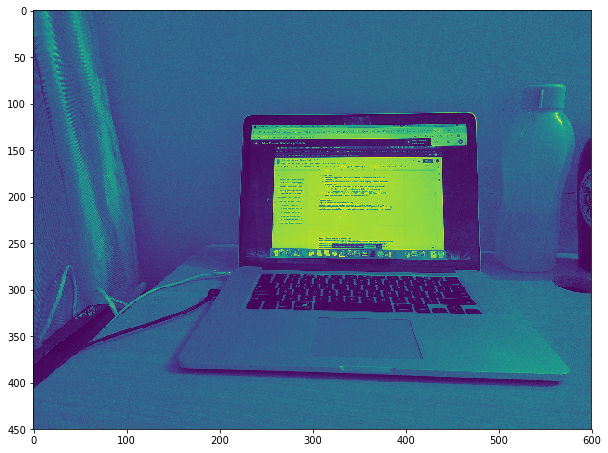

In [2]:
img = cv2.imread('/Users/tejaswin.p/Downloads/Fast_Brief/IMG_20200415_162336.jpg', cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (0, 0), fx=0.15, fy=0.15)

plt.figure(figsize=(10, 10))
plt.imshow(img);

### Create FAST features.

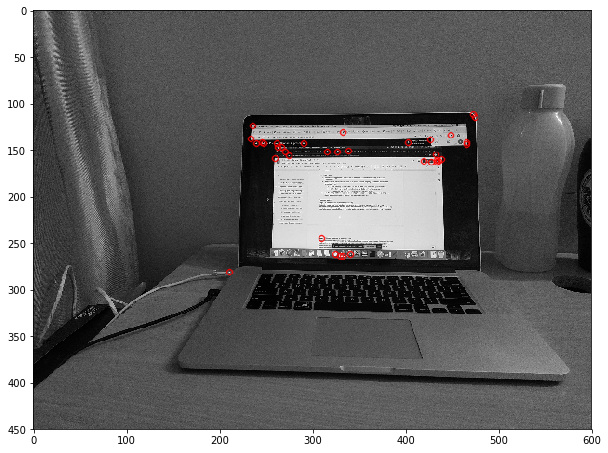

In [5]:
fast = cv2.FastFeatureDetector_create(threshold=150)
kps = fast.detect(img)

features = cv2.drawKeypoints(img, kps, None, color=(255,0,0))

plt.figure(figsize=(10, 10))
plt.imshow(features);

In [10]:
def get_patch(image, x, y, radius=10):
    patch = image[x-radius:x+radius+1, y-radius:y+radius+1]
    return patch

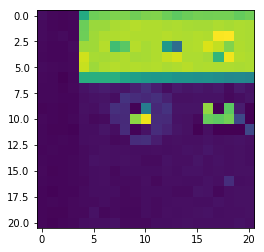

In [71]:
i = 10
y, x = kps[i].pt
x, y = int(x), int(y)

patch = get_patch(img, x, y)
plt.imshow(patch);

### Plot circular patch.

In [72]:
radius = 10
right = zip(range(-radius, radius+1), range(0, radius) + range(radius, -1, -1))
left = zip(range(radius-1, -radius, -1), range(-1, -radius, -1) + range(-radius, 1, 1))
circle_xy = right+left

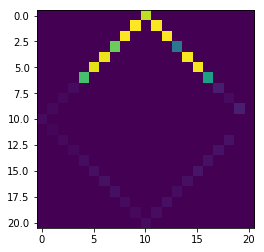

In [73]:
circle_patch = np.zeros_like(patch)
for i, j in circle_xy:
    circle_patch[radius+i, radius+j] = patch[radius+i, radius+j]

plt.imshow(circle_patch);

### Compute centroid and angle using `cv2.moments` and compare against your previous manual calculation ...

In [74]:
_mom = cv2.moments(np.float32(circle_patch))

In [75]:
centroid = (_mom['m10']/_mom['m00'] - radius, _mom['m01']/_mom['m00'] - radius)
print np.arctan2(-centroid[1], centroid[0]) * 180.0/np.pi

90.53922060491774


In [76]:
def compute_cv2_ica(masked_circular_patch, radius=0):
    m = cv2.moments(np.float32(masked_circular_patch))
    centroid = (m['m10']/m['m00'] - radius, m['m01']/m['m00'] - radius)
    return np.arctan2(-centroid[1], centroid[0])  # THIS IS RADIANS!!!

In [77]:
def compute_plot_ica(patch, radius):
    right = zip(range(-radius, radius+1), range(0, radius) + range(radius, -1, -1))
    left = zip(range(radius-1, -radius, -1), range(-1, -radius, -1) + range(-radius, 1, 1))

    circle = right + left
    print len(circle)

    plt.imshow(patch)
    ax = plt.gca()

    cx, cy = radius, radius
    p = patches.Rectangle(xy=(cx-0.5, cy-0.5), width=1, height=1, color='red')
    ax.add_patch(p);

    m00, m01, m10 = 0, 0, 0

    for ox, oy in circle:
        p = patches.Rectangle(xy=(cx+ox-0.5, cy+oy-0.5), width=1, height=1, fill=False, color='red')
        ax.add_patch(p);

        _ival = patch[cx+ox, cy+oy]
        m00 += _ival
        m01 += oy * _ival
        m10 += ox * _ival

    centroid = [m01/m00, m10/m00]
    print "centroid:", centroid
    print "degrees:", np.arctan2(-m10, m01) * 180 / np.pi

    p = patches.Rectangle(xy=(cx+centroid[0]-0.5, cy+centroid[1]+0.5), width=1, height=1, fill=True, color='orange')
    ax.add_patch(p);

40
centroid: [-0.05770012190166599, -6.130841121495327]
degrees: 90.53922060491774


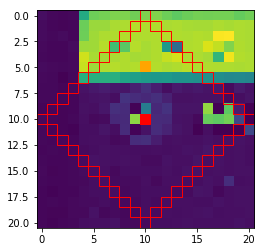

In [78]:
compute_plot_ica(np.float32(patch), 10)

In [65]:
brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()

### Construct rotation matrix for transformation

In [80]:
def make_rotation_matrix(angle_radians):
    return np.array([
        [np.cos(angle_radians), -np.sin(angle_radians)],
        [np.sin(angle_radians), np.cos(angle_radians)]
    ])

In [81]:
make_rotation_matrix(compute_cv2_ica(circle_patch, 10))

array([[-0.00941104, -0.99995572],
       [ 0.99995572, -0.00941104]])

### Doing feature matchings for two images using rotation BRIEF tests

In [90]:
import random

np.random.seed(1)
random.seed(1)

sites = []
for a in np.arange(-15, 16):
    for b in np.arange(-15, 16):
        sites.append((a, b))

p1 = random.sample(sites, 512)
p2 = random.sample(sites, 512)

print len(set(p1)), len(set(p2)), len(set(zip(p1, p2)))

512 512 512


In [109]:
### From a previous script in './fast_corner'

def get_fast_corners(image, threshold=26):
    fast = cv2.FastFeatureDetector_create()
    fast.setThreshold(threshold)
    fast.setNonmaxSuppression(1)

    kp = fast.detect(image, None)
    markers = cv2.drawKeypoints(image, kp, None, color=(255, 0, 0))

    return kp, markers


import pdb
def get_brief_descriptors(image, keypoints, pseq):
    descriptor = {}
    for val in keypoints:
        pixel = (int(val.pt[0]), int(val.pt[1]))
        vector = []

        try:
            for a, b in pseq:
                first = [a[1] + pixel[1], a[0] + pixel[0]]
                second = [b[1] + pixel[1], b[0] + pixel[0]]
                
                if val.angle != -1:
                    rot = make_rotation_matrix(val.angle)
                    first, second = np.int(np.dot(rot, np.array([first, second]).T).T)
                
                x = image[first[0], first[1]]
                y = image[second[0], second[1]]
                
                vector.append(x < y)

            descriptor[pixel] = vector

        except Exception as error:
            print "Failed for", pixel, error

    return descriptor

In [106]:
def get_centroid_angle(patch, radius=10):
    right = zip(range(-radius, radius+1), range(0, radius) + range(radius, -1, -1))
    left = zip(range(radius-1, -radius, -1), range(-1, -radius, -1) + range(-radius, 1, 1))
    
    circle_patch = np.zeros_like(patch)
    for i, j in right+left:
        circle_patch[radius+i, radius+j] = patch[radius+i, radius+j]
        
    m = cv2.moments(np.float32(circle_patch))
    centroid = (m['m10']/m['m00'] - radius, m['m01']/m['m00'] - radius)
    
    return np.arctan2(-centroid[1], centroid[0])  # THIS IS RADIANS!!!

### Load left and right images

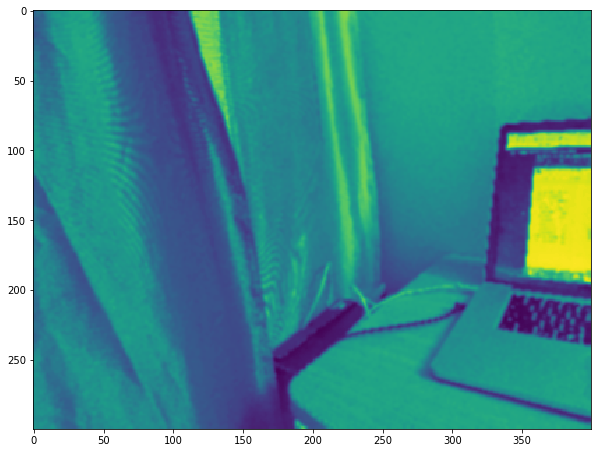

In [86]:
left = cv2.imread('/Users/tejaswin.p/Downloads/Fast_Brief/IMG_20200415_162333.jpg', cv2.IMREAD_GRAYSCALE)
left = cv2.resize(left, (0, 0), fx=0.1, fy=0.1)
left = cv2.GaussianBlur(left, (5, 5), 0)

plt.figure(figsize=(10, 10))
plt.imshow(left);

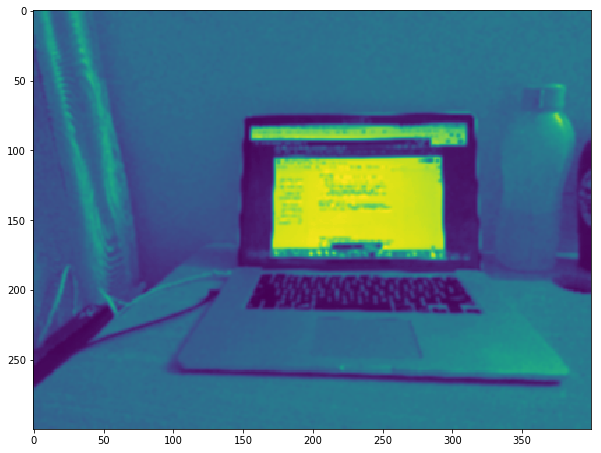

In [87]:
right = cv2.imread('/Users/tejaswin.p/Downloads/Fast_Brief/IMG_20200415_162336.jpg', cv2.IMREAD_GRAYSCALE)
right = cv2.resize(right, (0, 0), fx=0.1, fy=0.1)
right = cv2.GaussianBlur(right, (5, 5), 0)

plt.figure(figsize=(10, 10))
plt.imshow(right);

In [88]:
kp_left, markers_left = get_fast_corners(left)
kp_right, markers_right = get_fast_corners(right)

In [96]:
r = 15
patches_left = [get_patch(left, x=int(point.pt[1]), y=int(point.pt[0]), radius=r) for point in kp_left]
patches_right = [get_patch(right, x=int(point.pt[1]), y=int(point.pt[0]), radius=r) for point in kp_right]

In [102]:
# ica_left = [get_centroid_angle(p, r) for p in patches_left]
# ica_right = [get_centroid_angle(p, r) for p in patches_right]

for ix in range(len(kp_left)):
    if patches_left[ix].shape[0] == r*2+1 and patches_left[ix].shape[1] == r*2+1:
        angle = get_centroid_angle(patches_left[ix], r)
        kp_left[ix].angle = angle
        
for ix in range(len(kp_right)):
    if patches_right[ix].shape[0] == r*2+1 and patches_right[ix].shape[1] == r*2+1:
        angle = get_centroid_angle(patches_right[ix], r)
        kp_right[ix].angle = angle

In [110]:
brief_left = get_brief_descriptors(image=left, keypoints=kp_left, pseq=zip(p1, p2))

Failed for (338, 81) only size-1 arrays can be converted to Python scalars
Failed for (334, 85) only size-1 arrays can be converted to Python scalars
Failed for (341, 89) only size-1 arrays can be converted to Python scalars
Failed for (340, 97) only size-1 arrays can be converted to Python scalars
Failed for (62, 98) only size-1 arrays can be converted to Python scalars
Failed for (390, 100) index 401 is out of bounds for axis 1 with size 400
Failed for (343, 102) only size-1 arrays can be converted to Python scalars
Failed for (351, 102) only size-1 arrays can be converted to Python scalars
Failed for (359, 104) only size-1 arrays can be converted to Python scalars
Failed for (388, 104) index 400 is out of bounds for axis 1 with size 400
Failed for (362, 105) only size-1 arrays can be converted to Python scalars
Failed for (360, 114) only size-1 arrays can be converted to Python scalars
Failed for (365, 114) only size-1 arrays can be converted to Python scalars
Failed for (362, 116) 